Here we will provide code on how to recreate the plots for the cystic fibrosis results.

In [16]:
import os
import numpy as np
import pandas as pd
from biom import load_table
from skbio.stats.composition import clr, clr_inv, centralize, closure
from skbio.stats.ordination import OrdinationResults
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [17]:
data_dir = '../data/CF'

microbes = load_table(os.path.join(data_dir, 'otus_nt.biom')).to_dataframe().T
metabolites = load_table(os.path.join(data_dir, 'lcms_nt.biom')).to_dataframe().T

# align the samples
ids = set(microbes.index) & set(metabolites.index)
microbes = microbes.loc[ids]
metabolites = metabolites.loc[ids]

# to keep consistent with the mmvec analysis, microbes with less than 10 reads total are dropped
microbes = microbes.loc[:, (microbes>0).sum(axis=0) > 10]

In [18]:
!ls ../results/cf_output

arrow-metadata.txt
emperor.qzv
latent_dim_3_input_prior_1.00_output_prior_1.00_beta1_0.85_beta2_0.90
metabolites-pca.results
microbes-pca.results
model.txt
model_run13_CF_dim3_lr1e-4_beta10.9_beta20.99_sub100_batch10.txt
omics-biplot.results
ordination.qza
ordination.txt
ordination_run13_CF_dim3_lr1e-4_beta10.9_beta20.99_sub100_batch10.txt
point-metadata.txt
ranks.csv


In [19]:
model = pd.read_csv(
    '../results/cf_output/model_run13_CF_dim3_lr1e-4_beta10.9_beta20.99_sub100_batch10.txt',
    index_col=0
)

In [20]:
from scipy.sparse.linalg import svds

microbes = model.loc[model.embed_type=='microbe']
metabolites = model.loc[model.embed_type=='metabolite']
pc_ids = ['PC0', 'PC1', 'PC2']
microbes = microbes[['feature_id', 'axis', 'mean']].pivot(index='feature_id', columns='axis')
metabolites = metabolites[['feature_id', 'axis', 'mean']].pivot(index='feature_id', columns='axis')
microbes.columns = microbes.columns.droplevel()
metabolites.columns = metabolites.columns.droplevel()

microbes['ones'] = 1
metabolites['ones'] = 1
microbes = microbes[['bias', 'ones'] + pc_ids]
metabolites = metabolites[['ones', 'bias'] + pc_ids]

logits = microbes @ metabolites.T
logits = logits - logits.mean(axis=0)
logits = logits - logits.mean(axis=1).values.reshape(-1, 1)

u, s, v = svds(logits.values.T, k=3)
scale = 1.   # aspect ratios between metabolite points and microbe arrows
#n = v.shape[1]
#u = u * np.sqrt(n-1) / scale 
#v = scale * np.diag(s) @ v / np.sqrt(n-1)

pc_ids = ['PC0', 'PC1', 'PC2']
U = pd.DataFrame(u, index=microbes.index, columns=pc_ids)
V = pd.DataFrame(v.T, index=metabolites.index, columns=pc_ids)
eigvals = pd.Series(s, index=pc_ids)
proportion_explained = pd.Series(s**2 / np.sum(s**2), index=pc_ids)
res = OrdinationResults(
    short_method_name='Multiomics biplot',
    long_method_name='Multiomics biplot',
    samples=U, features=V, eigvals=eigvals, 
    proportion_explained=proportion_explained
)
res.write('../results/cf_output/ordination.txt')

ValueError: Shape of passed values is (462, 3), indices imply (138, 3)

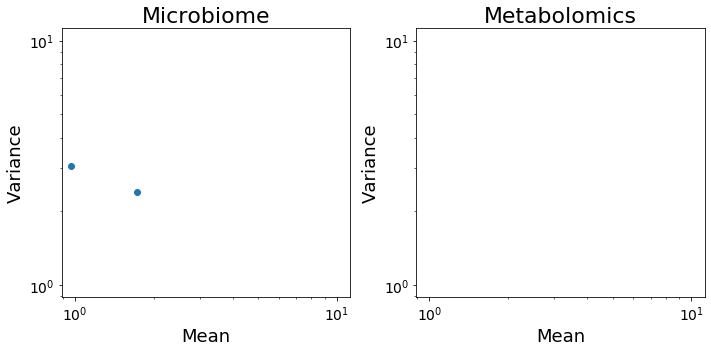

In [6]:
titlesize = 22
fontsize = 18
labelsize = 14
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(microbes.mean(axis=0), microbes.var(axis=0))
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Mean', fontsize=fontsize)
ax[0].set_ylabel('Variance', fontsize=fontsize)
ax[0].set_title('Microbiome', fontsize=titlesize)
ax[0].tick_params(axis='x', labelsize=labelsize)
ax[0].tick_params(axis='y', labelsize=labelsize)

ax[1].scatter(metabolites.mean(axis=0), metabolites.var(axis=0))
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Mean', fontsize=fontsize)
ax[1].set_ylabel('Variance', fontsize=fontsize)
ax[1].set_title('Metabolomics', fontsize=titlesize)
ax[1].tick_params(axis='x', labelsize=labelsize)
ax[1].tick_params(axis='y', labelsize=labelsize)

plt.tight_layout()

Let's load the `ranks.csv` and the `omics-biplot.results` files that were created earlier. 
We'll also load the feature metadata mapping files, since we will use this information to paint the biplots.

In [ ]:
data_dir = '../data/CF'
ranks = pd.read_csv('../results/cf_output/ranks.csv', index_col=0)
#biplot_res = OrdinationResults.read('../results/cf_output/omics-biplot.results')

taxonomy = pd.read_table(os.path.join(data_dir, 'taxonomy.tsv'), index_col=0)
ms1_md = pd.read_table(os.path.join(data_dir, 'lcms_annotations.txt'), index_col=0)

In [ ]:
biplot_res.samples

We'll want to do some preprocessing of the feature metadata to ease manipulation.  
Here, we'll just parse the taxonomies to make it easier to read.

In [ ]:
taxa = pd.DataFrame(taxonomy.Taxon.apply(lambda x: x.split(';')).values.tolist(), 
                    index=taxonomy.index, 
                    columns=['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'])

Cleaning up the metabolomics annotations is a little more tricky - we need to do two things

1. Match up the MS1 retention times and masses to the MS2 annotations
2. Clean up the chemical names.

I'm going to use a nearest neighbors approach regarding the retention times and masses.
The masses are expected to be more accurate (within +/- 1) whereas the retention times are expected to slip more (+/- 10).

We will need to extract the masses and retention ties from the ids.  Here the m/z is the first value and the retention time is the second value.

# WARNING!!!

As of now, there is no standardized protocol for labeling MS1 features.  Some MS1 bucket tables will be labeled with scan ids, or have the retention time and m/z flipped. So proceed with caution.

That can be done as follows

In [ ]:
from scipy.spatial import KDTree

ms_ids = ranks.columns
mz = list(map(lambda x: float(x[1:].split('mz')[0]), ms_ids))
rt = list(map(lambda x: float(x[1:].split('mz')[1]), ms_ids))
df = pd.DataFrame({'measured_mz': mz, 'measured_rt': rt}, index=ms_ids)

We will create a database from the MS1 annotations, so that we will be matching the MS1 labels to the MS2 labels.
We will only be looking at the closest neighbor and we will be recording their distances and original retention time and m/z.

In [ ]:
lookup = KDTree(ms1_md[['Precursor_MZ', 'RT_Query']])
d, i = lookup.query(df.values, k=1, eps=.1)

df['nearest_distance'] = d
df['scan'] = [ms1_md.index[k] for k in i]
df = df.reset_index()

Now we will merge the MS1 and MS2 annotations together.

In [ ]:
ms1_md = ms1_md.reset_index()
ms_md = pd.merge(df, ms1_md, left_on='scan', right_on='#Scan#')
ms_md = ms_md.set_index('index')

Now that we have some sort of unified metabolite annotation metadata, we can now start digging into individual molecules.

Since P. aeruginosa is the best understood microbe in this system, we'll start by focusing on its known molecules, 
and merging that information into our metabolite annotations metadata.

In [ ]:
data_dir = '../data/CF'
validation = pd.read_csv(
    os.path.join(data_dir, 'validated-molecules.csv'), 
    index_col=0, header=None
) 
validation.columns = ['rank', 'expert_annotation', 'shorthand']
ms_md = pd.merge(ms_md, validation, left_index=True, right_index=True, how='left')

Now we will want to start cleaning up some of the chemical names.  This is mainly for the
sake of visualization (since many of these names are just too darn long).

In [ ]:
ms_md['shorthand'] = ms_md['shorthand'].fillna('None')

def annotation_f(x):
    if x['shorthand'] != 'None':
        return x['shorthand']
    if x['nearest_distance'] > 10 or len(x['Compound_Name']) > 30:
        return 'Other'
    if x['Compound_Name'] == 'Rha-Rha-C10-C10 (M+H)':
        return 'Rhamnolipid'
    if 'phosphocholine' in x['Compound_Name']:
        return 'Phosphocholine'
    if 'Palmitoylcarnitine' in x['Compound_Name']:
        return 'Palmitoylcarnitine'
    if 'phosphoethanolamine' in x['Compound_Name']:
        return 'Phosphoethanolamine'
    if 'butyrolactone' in x['Compound_Name']:
        return 'Butyrolactone'
    if 'indole' in x['Compound_Name'].lower():
        return 'indole'
    else:
        return x['Compound_Name']
    
ms_md['shorthand'] = ms_md.apply(annotation_f, axis=1)
ms_md.index.name = 'sampleid'

Before something else breaks, let's save all of the feature metadata files.
We can use these files for visualization later.

In [ ]:
ms_md.to_csv('../results/cf_output/point-metadata.txt', sep='\t')

taxa.index.name = 'featureid'
taxa.to_csv('../results/cf_output/arrow-metadata.txt', sep='\t')

Now we will make a custom biplot -- it is going to be hairy, so take a deep breath.

In [ ]:
from scipy.spatial.distance import euclidean
 
axis0='PC0'
axis1='PC1'
# only plot the top 30 features
features = biplot_res.features
features['importance'] = features.apply(lambda x: euclidean(np.zeros_like(x), x), axis=1)
features.sort_values('importance', inplace=True, ascending=False)
features.drop(['importance'], inplace=True, axis=1)
biplot_res.features = features[:30]

# Now actually make the biplot
fig = plt.figure(figsize=(8, 8))

ridx = ms_md.loc[ms_md.shorthand == 'Rhamnolipid'].index
idx = ms_md.loc[ms_md.shorthand != 'Rhamnolipid'].index

rhamolipid_color = '#C918C1'
other_color = '#B2B2B2'
fermenter_color = '#00B899'
anaerobe_color = '#C69600'

arrow_width = .01
other = plt.scatter(biplot_res.samples.loc[idx, axis0], 
                    biplot_res.samples.loc[idx, axis1], 
                    color=other_color, label='other')
for i in biplot_res.features.index:
    label = taxa.loc[i, 'genus']    
    if label == ' g__Pseudomonas':
        pseudomonas = plt.arrow(
            0, 0, biplot_res.features.loc[i, axis0], biplot_res.features.loc[i, axis1], 
            color='r', width=arrow_width)        
    elif biplot_res.features.loc[i, 'PC0'] > 0:        
        pathogens = plt.arrow(
            0, 0, biplot_res.features.loc[i, axis0], biplot_res.features.loc[i, axis1], 
            color=fermenter_color, width=arrow_width)
    else:
        anaerobes = plt.arrow(
            0, 0, biplot_res.features.loc[i, axis0], biplot_res.features.loc[i, axis1], 
            color=anaerobe_color, width=arrow_width)

rhamnolipids = plt.scatter(biplot_res.samples.loc[ridx, axis0], 
                           biplot_res.samples.loc[ridx, axis1], s=50,
                           color=rhamolipid_color, zorder=5, label='Rhamnolipid')

compounds = [
    'Pyochelin', 'Phenazine-1-carboxylic Acid', 
    'HHQ', 'NHQ', 'C9:db-PQS, C9:DB-NQNO', 
    'PQS/HQNO', 'Pyocyanin'
]

interesting_taxa = [' g__Pseudomonas', ' g__Prevotella', ' g__Veillonella', 
                    ' g__Fusobacterium']


compound_idx = [ms_md.loc[c, 'shorthand'] in compounds for c in ms_md.index]
compound_idx = ms_md.loc[compound_idx].index
subsamples = biplot_res.samples.loc[compound_idx]
plt.scatter(subsamples[axis0], subsamples[axis1], marker='+',
            color='k', s=100, zorder=10)

for i in subsamples.index:
    x, y = subsamples.loc[i, axis0], subsamples.loc[i, axis1]
    label = ms_md.loc[i, 'shorthand']
    dx = np.sign(x)*50
    dy = np.sign(y)*50
    plt.annotate(
        label,
        xy=(x, y), xytext=(dx, dy),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

for i in biplot_res.features.index:
    x, y = biplot_res.features.loc[i, axis0], biplot_res.features.loc[i, axis1]
    label = taxa.loc[i, 'genus']
    if label not in interesting_taxa: continue
        
    dx = np.sign(x)*30
    dy = np.sign(y)*30
    plt.annotate(
        label,
        xy=(x, y), xytext=(dx, dy),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.legend([pseudomonas, pathogens, anaerobes, rhamnolipids], 
           ['pseudomonas', 'pathogens', 'anaerobes', 'rhamnolipids'], 
           fontsize=12, loc=4)

#plt.legend()
plt.xlim([-4, 2])
plt.ylim([-2.5, 2])
plt.xticks([])
plt.yticks([])
plt.xlabel('PC1', fontsize=24)
plt.ylabel('PC2', fontsize=24)
plt.savefig('../results/custom-cf-omics.pdf')

So, this looks pretty ugly right?

This plot was ultimately tidied up in inkscape, since there are so many labels.
This is another motivation to push these sorts of plotting capabilities to Emperor.

Another thing worth doing is to compare and contrast the P. aeruginosa results between the conditional probabilities and the Pearson correlations.

Let's retrieve the original microbe/metabolite data and match their samples.

In [ ]:
data_dir = '../data/CF/'

microbes = load_table(os.path.join(data_dir, 'otus_nt.biom')).to_dataframe().T
metabolites = load_table(os.path.join(data_dir, 'lcms_nt.biom')).to_dataframe().T

# cast to dense dataframes and normalize to 1
microbes = pd.DataFrame(microbes).apply(lambda x: x / x.sum(), axis=1)
metabolites = pd.DataFrame(metabolites).apply(lambda x: x / x.sum(), axis=1)


# align the samples
ids = set(microbes.index) & set(metabolites.index)
microbes = microbes.loc[ids]
metabolites = metabolites.loc[ids]

# to keep consistent with the minstrel analysis, microbes with less than 10 reads total are dropped
microbes = microbes.loc[:, (microbes>0).sum(axis=0) > 10]

Let's calculate the Pearson correlation coefficients.

In [ ]:
from scipy.stats import spearmanr, pearsonr

# extract the P. aeroginosa deblurred sequence
pseudomonas = taxa.loc[(taxa['genus'] == ' g__Pseudomonas').values].index[0]

# extract the P. aeroginosa ranks / probabilities.
pranks = ranks.loc[pseudomonas].sort_values()

pear_ranks = pd.Series(index=ms_md.index)
pear_pvals = pd.Series(index=ms_md.index)
pranks = pranks.loc[pear_ranks.index]

for i in ms_ids:
    r = pearsonr(list(microbes[pseudomonas].values), list(metabolites[i].values))
    pear_ranks.loc[i] = r[0]
    pear_pvals.loc[i] = r[1]    

The comparison between the Pearson and Conditional probabilities is given below.
The conditional probabilities here are log transformed and centered around the mean log.

The dots are all sized by the -log pvalue from Pearson correlation.

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(pranks, pear_ranks, s=-2*np.log(pear_pvals))
ax.scatter(pranks.loc[ridx], pear_ranks.loc[ridx], color='r', 
            s=-2*np.log(pear_pvals.loc[ridx]), label='rhamnolipids')
ax.set_xlabel('Conditional logits', fontsize=18)
ax.set_ylabel('Pearson coefficients', fontsize=18)
ax.set_title('P. aeruginosa molecular ranks', fontsize=18)
ax.legend(loc=4, fontsize=14)

compounds = pd.DataFrame({
    'X211.0918mz161.2083': ['Pyocyanin', 30, -60],
    'X325.0673mz300.6387': ['Pyochelin', -80, 40],
    'X232.1329mz284.2357': ['PCA', 50, -25],
    'X244.1681mz317.3049': ['HHQ', 30, -30],
    'X258.1804mz348.1582': ['PQS/HQNO', -80, 10],
    'X256.1688mz350.8455': ['PQS/HQNO', -20, 30],
    'X273.2005mz375.3707': ['NHQ', -70, 20],
    'X271.1934mz377.8070': ['NHQ', 80, -35],
    'X272.2311mz381.5715': ['NHQ', -30, 40],
    'X289.2395mz367.6799': ['NQNO', 10, -50],
    'X295.1511mz367.9210': ['NQNO', 30, 30],
    'X284.1965mz373.1668': ['NQNO', -30, 10]
}, ['compound', 'dx', 'dy']).T

subsamples = pd.merge(biplot_res.samples, compounds, left_index=True, right_index=True)

for i in subsamples.index:
    x, y = pranks.loc[i], pear_ranks.loc[i]
    dx, dy = subsamples.loc[i, 'dx'], subsamples.loc[i, 'dy']
    
    label = subsamples.loc[i, 'compound']
    #dx = np.sign(x)*50
    #dy = np.sign(y)*50
    ax.annotate(
        label,
        xy=(x, y), xytext=(dx, dy),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
plt.tight_layout()
plt.savefig('../results/rhamnolipids_comparison.png')

We can zoom in on the Rhamnolipids to see how the ranks compare

In [ ]:
from scipy.stats import rankdata
fig, ax = plt.subplots(figsize=(5, 5))

conditional_ranks = pd.Series(rankdata(-pranks), pranks.index)
pearson_ranks = pd.Series(rankdata(-pear_ranks), pear_ranks.index)
k = conditional_ranks.sort_values().iloc[:30].index

ax.scatter(list(conditional_ranks.loc[k].values),
            list(pearson_ranks.loc[k].values))
ax.scatter(list(conditional_ranks.loc[ridx].values),
            list(pearson_ranks.loc[ridx].values), label='rhamnolipids', c='r')
ax.plot(np.linspace(0,30), np.linspace(0,30), c='r')
ax.set_xlabel('Conditional ranks', fontsize=18)
ax.set_ylabel('Pearson ranks', fontsize=18)

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))

plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('../results/rhamnolipid_ranks.png')

Below are some stats for Pearson correlation

In [ ]:
from statsmodels.stats.multitest import multipletests

# annotated compounds known to be produced by Pseudomonas
compounds = [
    'Pyochelin', 'Phenazine-1-carboxylic Acid', 
    'HHQ', 'NHQ', 'C9:db-PQS, C9:DB-NQNO', 
    'PQS/HQNO', 'Pyocyanin'
]
compound_idx = [ms_md.loc[c, 'shorthand'] in compounds for c in ms_md.index]

print('Total detected with Pearson with FDR correction', 
      multipletests(pear_pvals, method='fdr_bh')[0].sum())

print('Annotated compounds detected with Pearson without FDR correction', 
      (pear_pvals[compound_idx] < 0.05).sum())

print('Annotated compounds detected with Pearson with FDR correction', 
      (multipletests(pear_pvals, method='fdr_bh')[0][compound_idx]).sum())

print('Number of Rhamnolipids detected by Pearson without FDR correction', 
      (pear_pvals[ridx] < 0.05).sum())

print('Number of Rhamnolipids detected by Pearson with FDR correction', 
      pd.Series((multipletests(pear_pvals, method='fdr_bh')[0]), 
                index=pear_pvals.index).loc[ridx].sum())

To look in more detail about the specific correlations, we can look at the P. aeruginosa abundance vs Pyocyanin (which was quite different between the two)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
j = 'X211.0918mz161.2083' # pyocyanin
ax.scatter(list(microbes[pseudomonas].values),
            list(metabolites[j].values))
ax.set_xlabel(r'$\it{P. aeruginosa}$ proportion', fontsize=18)
ax.set_ylabel('Pyocyanin proportion', fontsize=18)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
plt.tight_layout()
plt.savefig('../results/pyocyanin_P.aeruginosa.png')